In [3]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import librosa
from scipy import signal
from scipy.fft import fft, fftfreq
import seaborn as sns

# Set up plotting style
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

# Read the audio file
file_path = r"D:\voice_processing\data\SpeechCommands\speech_commands_v0.02\go\00b01445_nohash_0.wav"

try:
    sr, audio = wavfile.read(file_path)
    audio = audio.astype(float)
    print(f"File loaded successfully: SR={sr}, Duration={len(audio)/sr:.2f}s")
except Exception as e:
    print(f"Error loading file: {e}")
    # Create synthetic audio for demonstration
    sr = 16000
    duration = 1.0
    t = np.linspace(0, duration, int(sr * duration))
    audio = 0.5 * np.sin(2 * np.pi * 220 * t) + 0.2 * np.sin(2 * np.pi * 440 * t)
    audio[:len(audio)//3] += 0.1 * np.random.normal(size=len(audio)//3)
    print("Using synthetic audio for demonstration")

# Normalize audio
audio = audio / np.max(np.abs(audio))
time = np.linspace(0, len(audio)/sr, len(audio))

# Parameters for frame-based analysis
frame_length = int(0.025 * sr)  # 25ms
hop_length = int(0.010 * sr)    # 10ms

File loaded successfully: SR=16000, Duration=1.00s


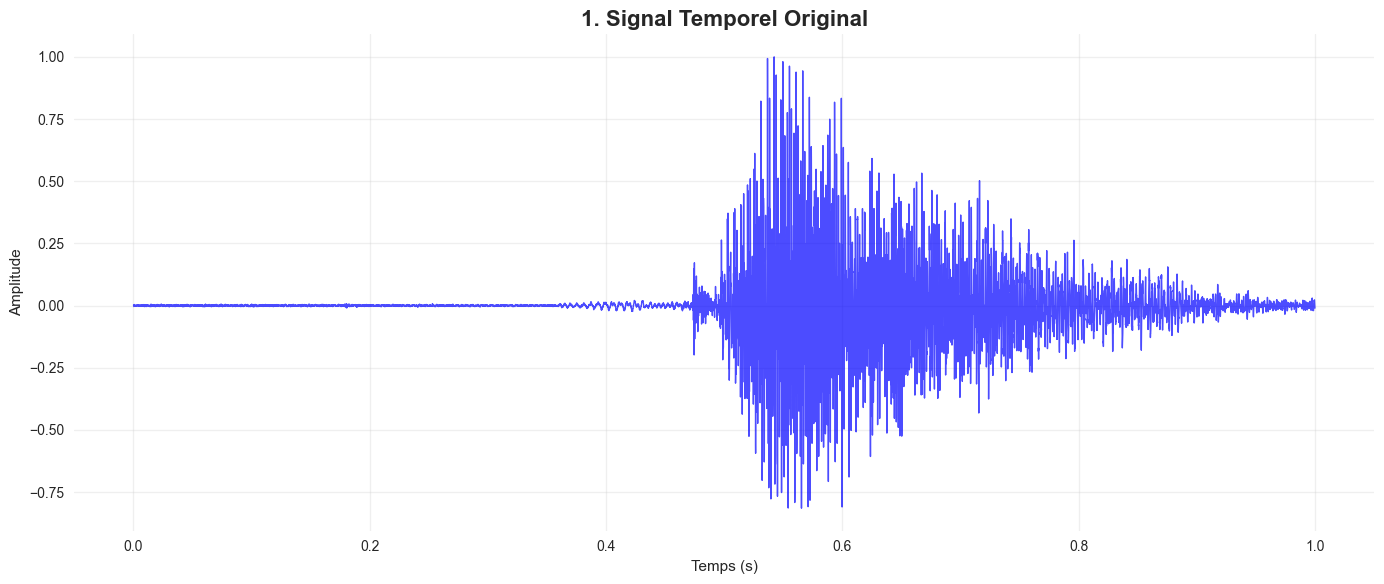

In [4]:
# 1. SIGNAL TEMPOREL ORIGINAL
plt.figure(figsize=(14, 6))
plt.plot(time, audio, linewidth=1, color='blue', alpha=0.7)
plt.title('1. Signal Temporel Original', fontsize=16, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

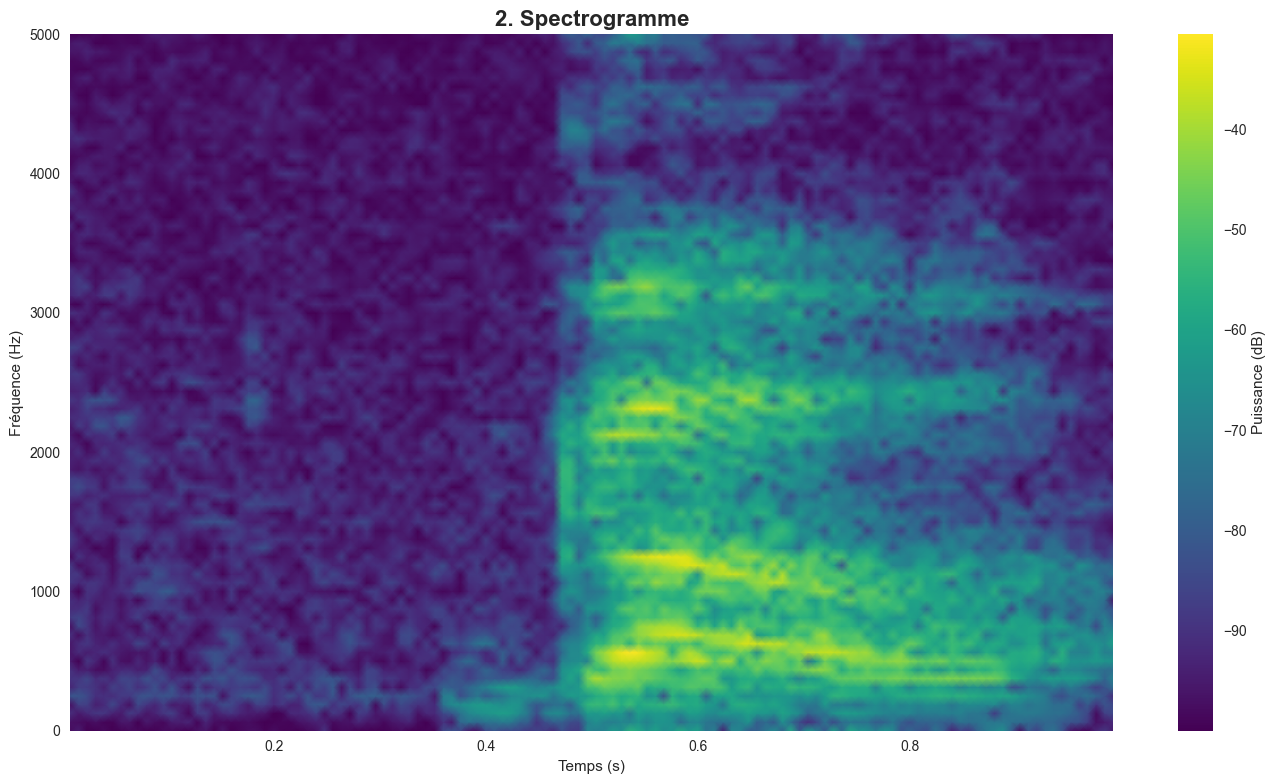

In [5]:
# 2. SPECTROGRAMME
plt.figure(figsize=(14, 8))
nperseg = 256
noverlap = nperseg // 2
frequencies, times, Sxx = signal.spectrogram(audio, sr, nperseg=nperseg, noverlap=noverlap)
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx + 1e-10), 
               shading='gouraud', cmap='viridis')
plt.title('2. Spectrogramme', fontsize=16, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('Fréquence (Hz)')
plt.colorbar(label='Puissance (dB)')
plt.ylim(0, 5000)
plt.tight_layout()
plt.show()

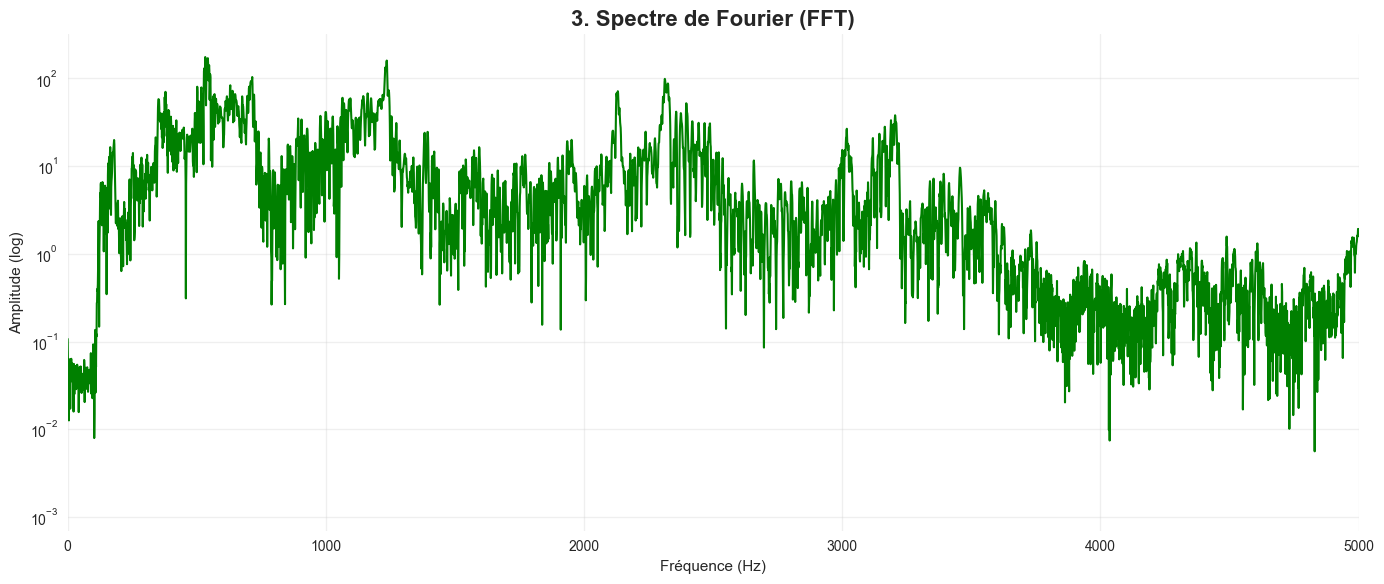

In [6]:
# 3. SPECTRE DE FOURIER (FFT)
plt.figure(figsize=(14, 6))
N = len(audio)
freqs = fftfreq(N, 1/sr)[:N//2]
spectrum = np.abs(fft(audio))[:N//2]

plt.semilogy(freqs, spectrum, linewidth=1.5, color='green')
plt.title('3. Spectre de Fourier (FFT)', fontsize=16, fontweight='bold')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude (log)')
plt.grid(True, alpha=0.3)
plt.xlim(0, 5000)
plt.tight_layout()
plt.show()

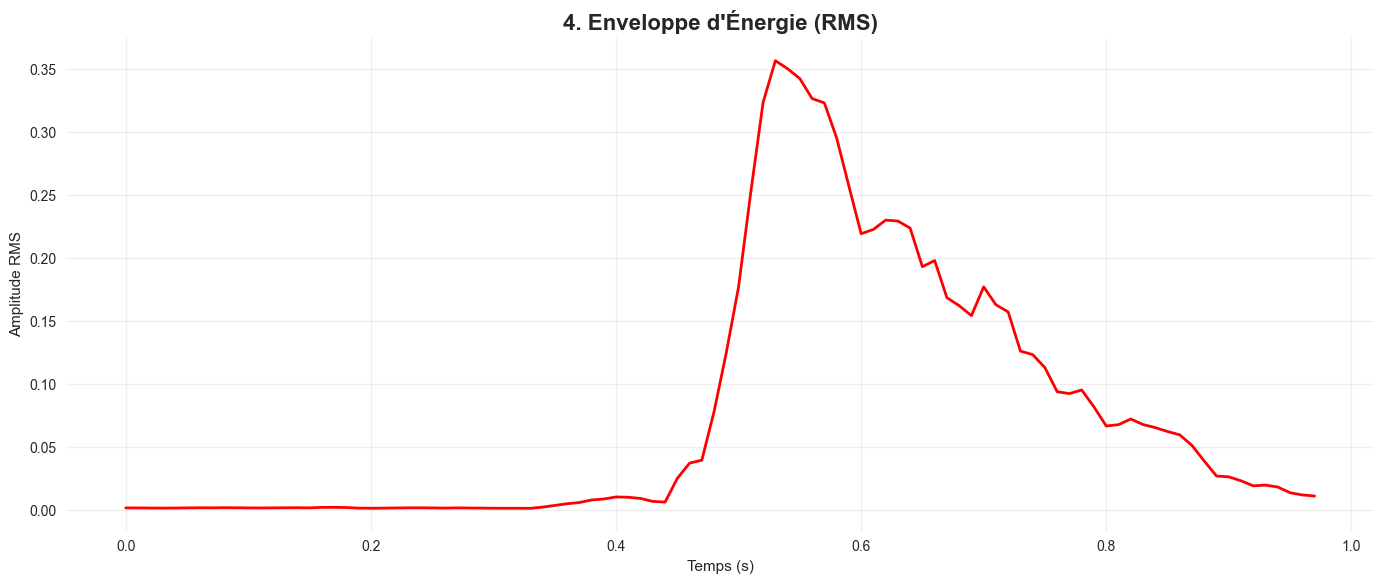

In [7]:
# 4. ENVELOPPE D'ÉNERGIE (RMS)
plt.figure(figsize=(14, 6))

# Calculate RMS energy
rms_energy = []
for i in range(0, len(audio) - frame_length, hop_length):
    frame = audio[i:i + frame_length]
    rms_energy.append(np.sqrt(np.mean(frame**2)))

energy_time = np.arange(len(rms_energy)) * hop_length / sr

plt.plot(energy_time, rms_energy, linewidth=2, color='red')
plt.title('4. Enveloppe d\'Énergie (RMS)', fontsize=16, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude RMS')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

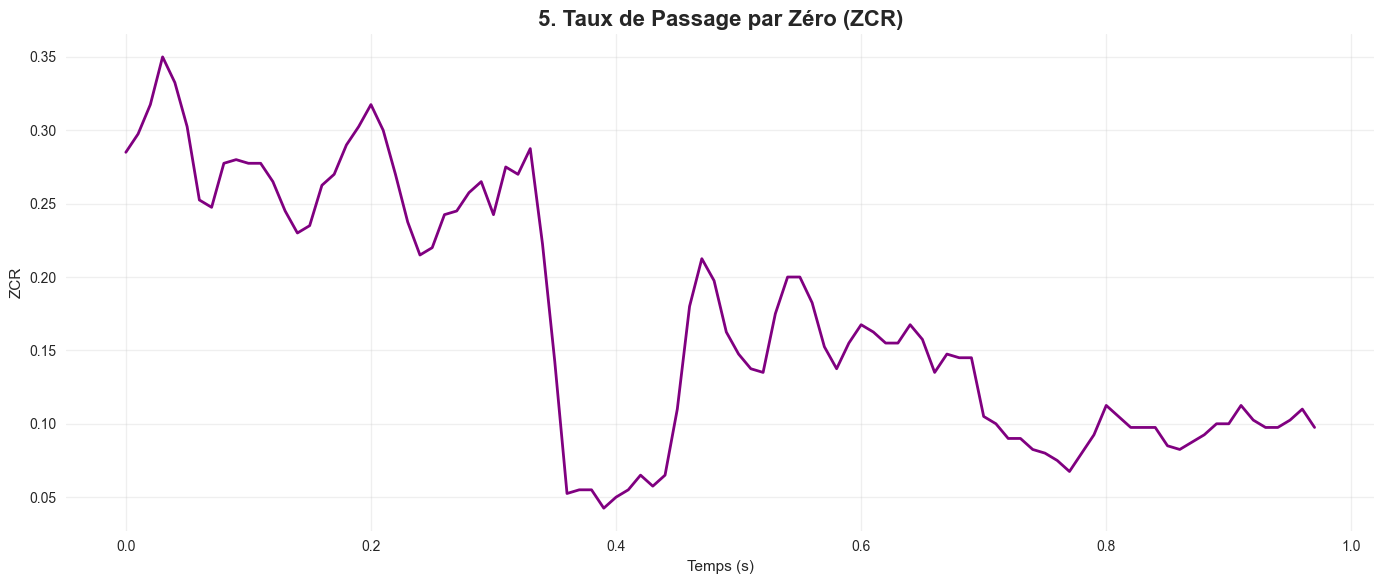

In [8]:
# 5. TAUX DE PASSAGE PAR ZÉRO (ZCR)
plt.figure(figsize=(14, 6))

zcr = []
for i in range(0, len(audio) - frame_length, hop_length):
    frame = audio[i:i + frame_length]
    zcr.append(np.sum(np.abs(np.diff(np.sign(frame)))) / (2 * len(frame)))

zcr_time = np.arange(len(zcr)) * hop_length / sr

plt.plot(zcr_time, zcr, linewidth=2, color='purple')
plt.title('5. Taux de Passage par Zéro (ZCR)', fontsize=16, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('ZCR')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

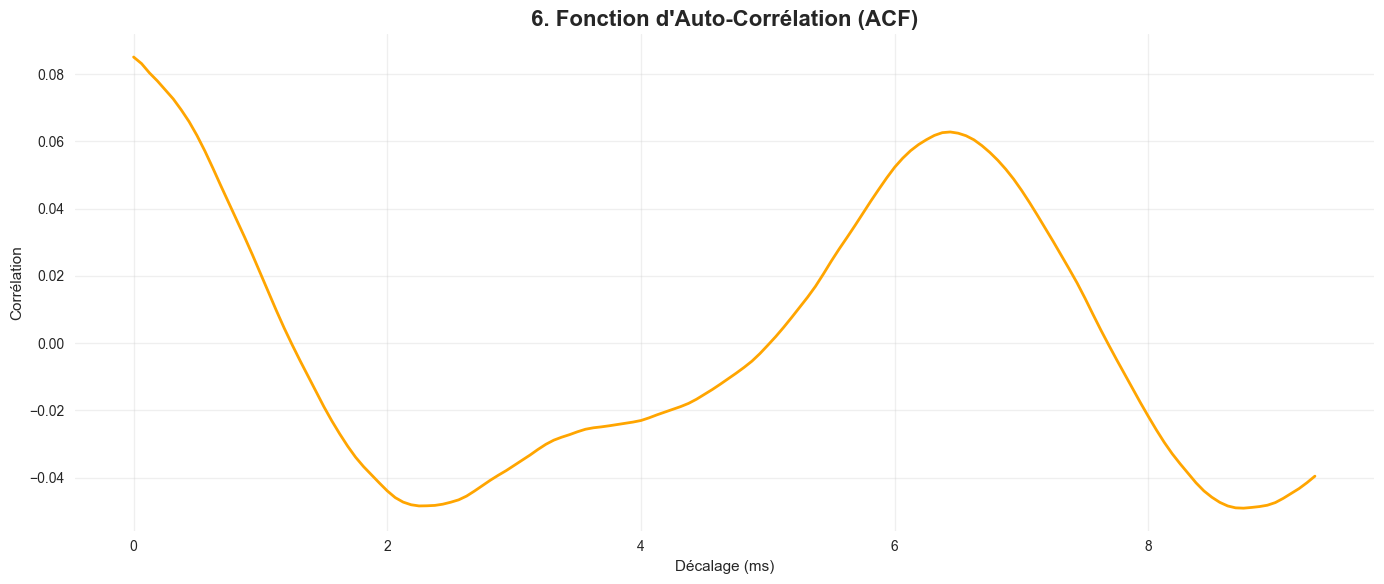

In [9]:
# 6. FONCTION D'AUTO-CORRÉLATION (ACF)
plt.figure(figsize=(14, 6))

# Take a middle segment for ACF analysis
segment_start = len(audio) // 3
segment_end = segment_start + int(0.1 * sr)  # 100ms segment
audio_segment = audio[segment_start:segment_end]

correlation = np.correlate(audio_segment, audio_segment, mode='full')
correlation = correlation[len(correlation)//2:]
lags = np.arange(len(correlation)) / sr * 1000  # in milliseconds

plt.plot(lags[:150], correlation[:150], linewidth=2, color='orange')
plt.title('6. Fonction d\'Auto-Corrélation (ACF)', fontsize=16, fontweight='bold')
plt.xlabel('Décalage (ms)')
plt.ylabel('Corrélation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

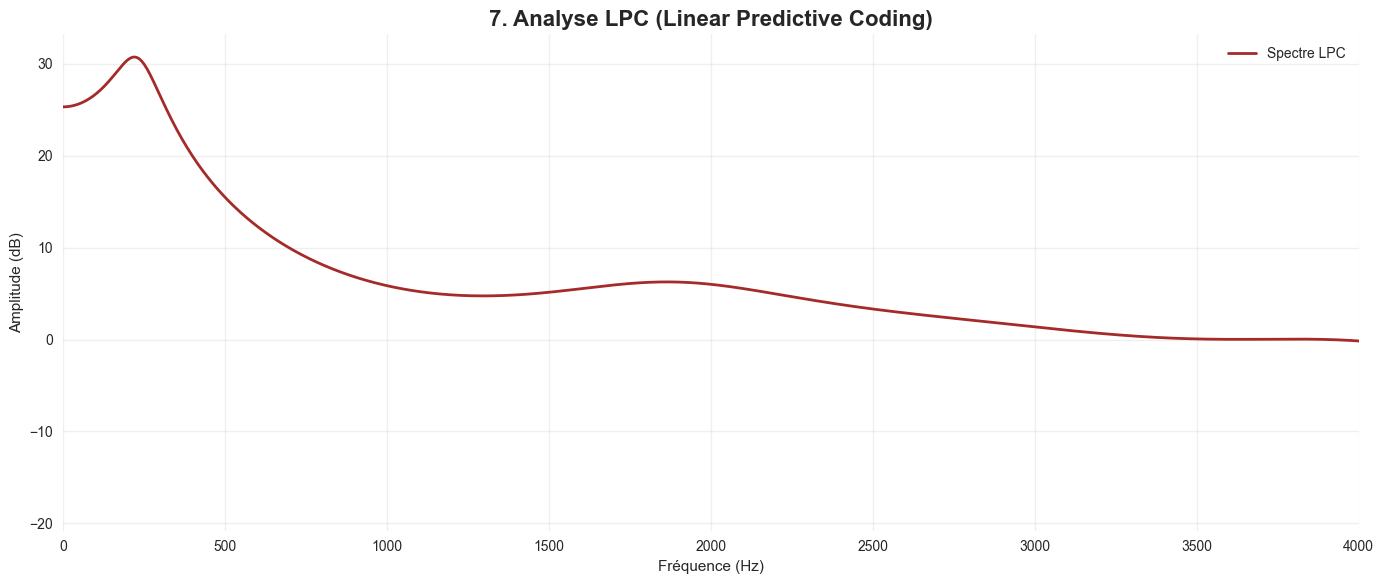

In [10]:
# 7. ANALYSE LPC (Linear Predictive Coding)
plt.figure(figsize=(14, 6))

def lpc_analysis(signal, order):
    """Compute LPC coefficients using autocorrelation method"""
    r = np.correlate(signal, signal, mode='full')
    r = r[len(r)//2:len(r)//2+order+1]
    
    a = np.zeros(order+1)
    e = np.zeros(order+1)
    a[0] = 1.0
    e[0] = r[0]
    
    for i in range(1, order+1):
        k = -np.sum(a[:i] * r[i:0:-1]) / e[i-1]
        a[1:i+1] = a[1:i+1] + k * a[i-1::-1]
        a[i] = k
        e[i] = (1 - k*k) * e[i-1]
    
    return a, e[-1]

order = 12
lpc_coeffs, error = lpc_analysis(audio_segment, order)
w, h = signal.freqz(1, lpc_coeffs, worN=2000)
lpc_freq = w * sr / (2 * np.pi)
lpc_mag = 20 * np.log10(np.abs(h) + 1e-10)

plt.plot(lpc_freq, lpc_mag, linewidth=2, color='brown', label='Spectre LPC')
plt.title('7. Analyse LPC (Linear Predictive Coding)', fontsize=16, fontweight='bold')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude (dB)')
plt.grid(True, alpha=0.3)
plt.xlim(0, 4000)
plt.legend()
plt.tight_layout()
plt.show()

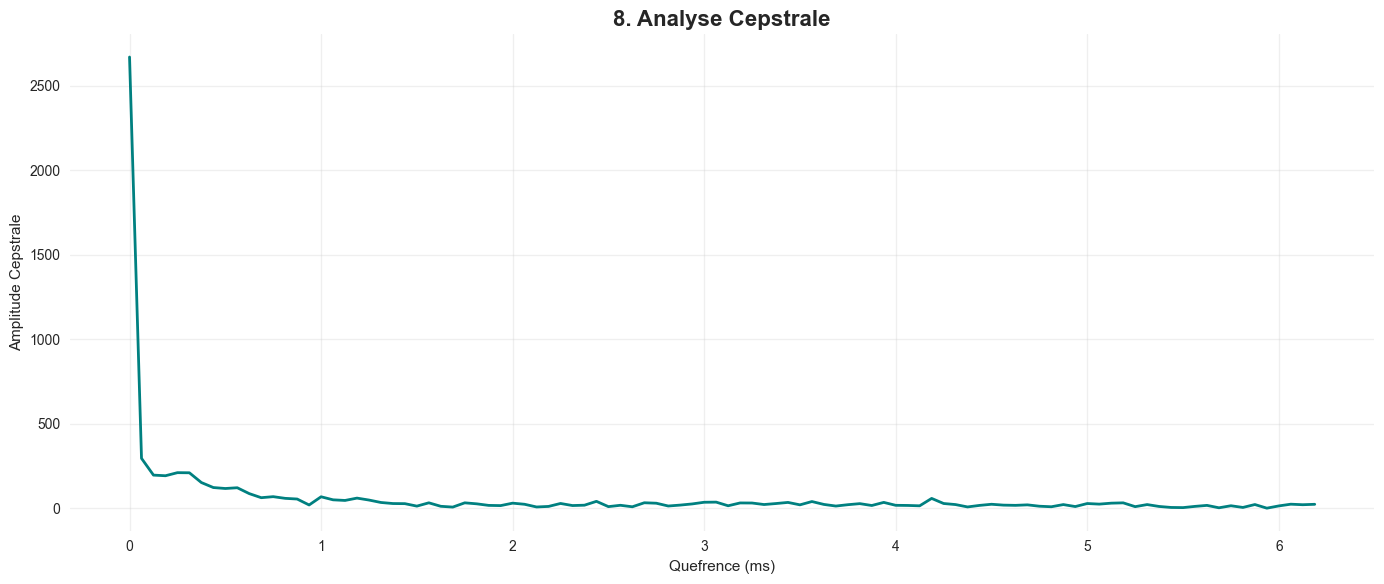

In [11]:
# 8. ANALYSE CEPSTRALE
plt.figure(figsize=(14, 6))

# Compute cepstrum
spectrum = np.abs(fft(audio_segment))
log_spectrum = np.log(spectrum[:len(spectrum)//2] + 1e-10)
cepstrum = np.abs(fft(log_spectrum))

quefrency = np.arange(len(cepstrum)) / sr * 1000  # in milliseconds

plt.plot(quefrency[:100], cepstrum[:100], linewidth=2, color='teal')
plt.title('8. Analyse Cepstrale', fontsize=16, fontweight='bold')
plt.xlabel('Quefrence (ms)')
plt.ylabel('Amplitude Cepstrale')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

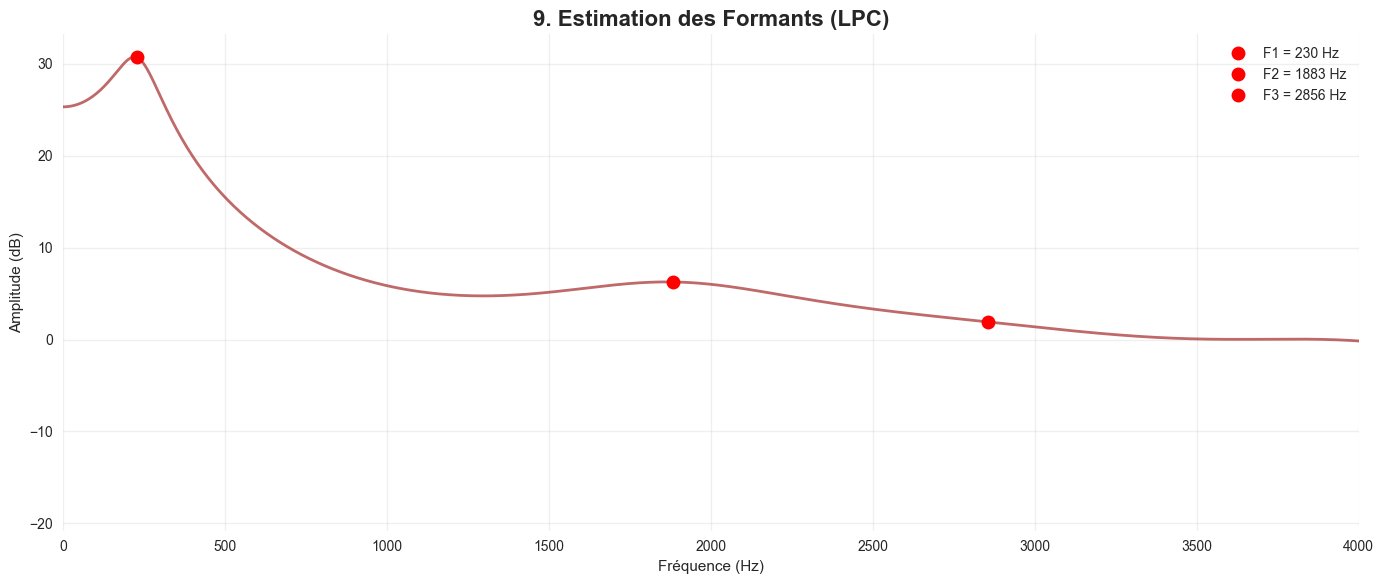

In [12]:
# 9. ESTIMATION DES FORMANTS (LPC)
plt.figure(figsize=(14, 6))

# Find poles of LPC filter
rts = np.roots(lpc_coeffs)
rts = rts[np.imag(rts) >= 0]
angz = np.arctan2(np.imag(rts), np.real(rts))
formants = angz * (sr / (2 * np.pi))
formants = np.sort(formants)

# Plot formant locations on LPC spectrum
plt.plot(lpc_freq, lpc_mag, linewidth=2, alpha=0.7, color='brown')
for i, f in enumerate(formants[:3]):  # First 3 formants
    if f < 4000 and f > 50:
        idx = np.argmin(np.abs(lpc_freq - f))
        plt.plot(f, lpc_mag[idx], 'ro', markersize=10, 
                label=f'F{i+1} = {f:.0f} Hz')

plt.title('9. Estimation des Formants (LPC)', fontsize=16, fontweight='bold')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude (dB)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 4000)
plt.tight_layout()
plt.show()

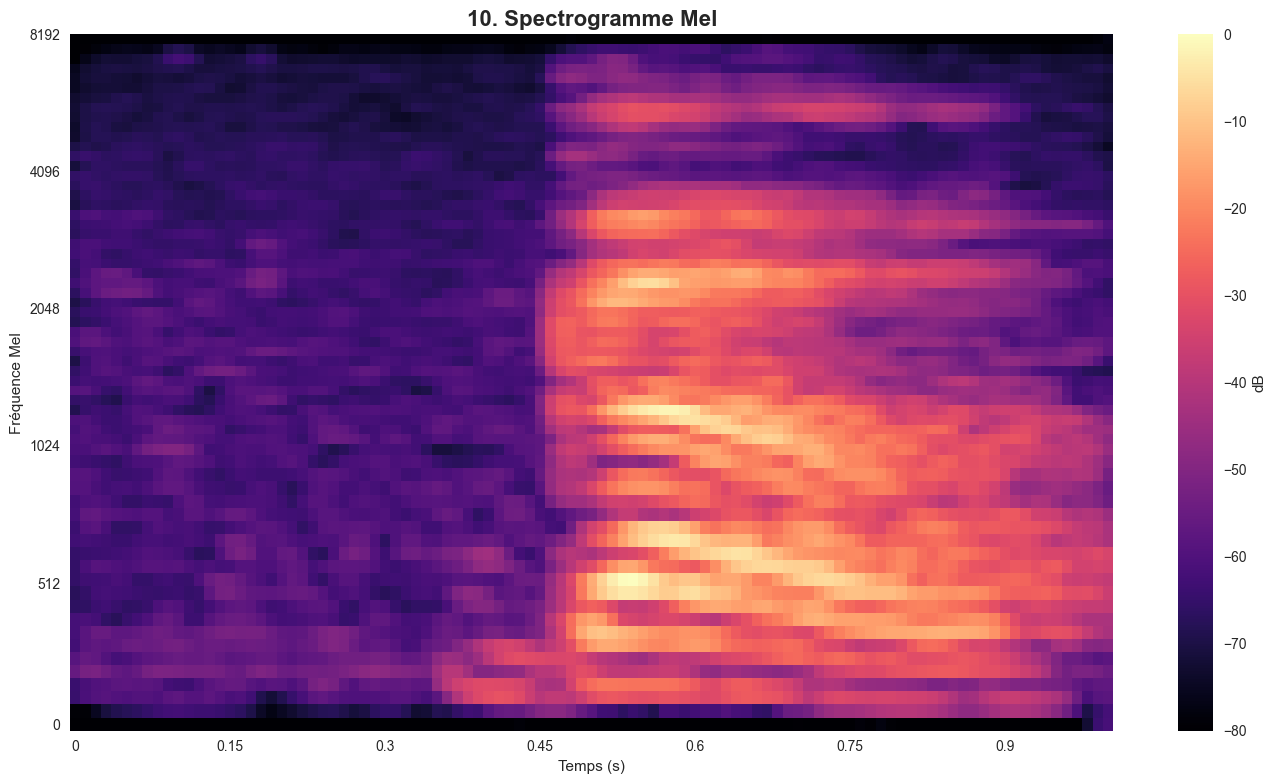

In [13]:
# 10. SPECTROGRAMME MEL
plt.figure(figsize=(14, 8))

mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=64, 
                                         hop_length=hop_length, n_fft=1024)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel', cmap='magma')
plt.title('10. Spectrogramme Mel', fontsize=16, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('Fréquence Mel')
plt.colorbar(label='dB')
plt.tight_layout()
plt.show()

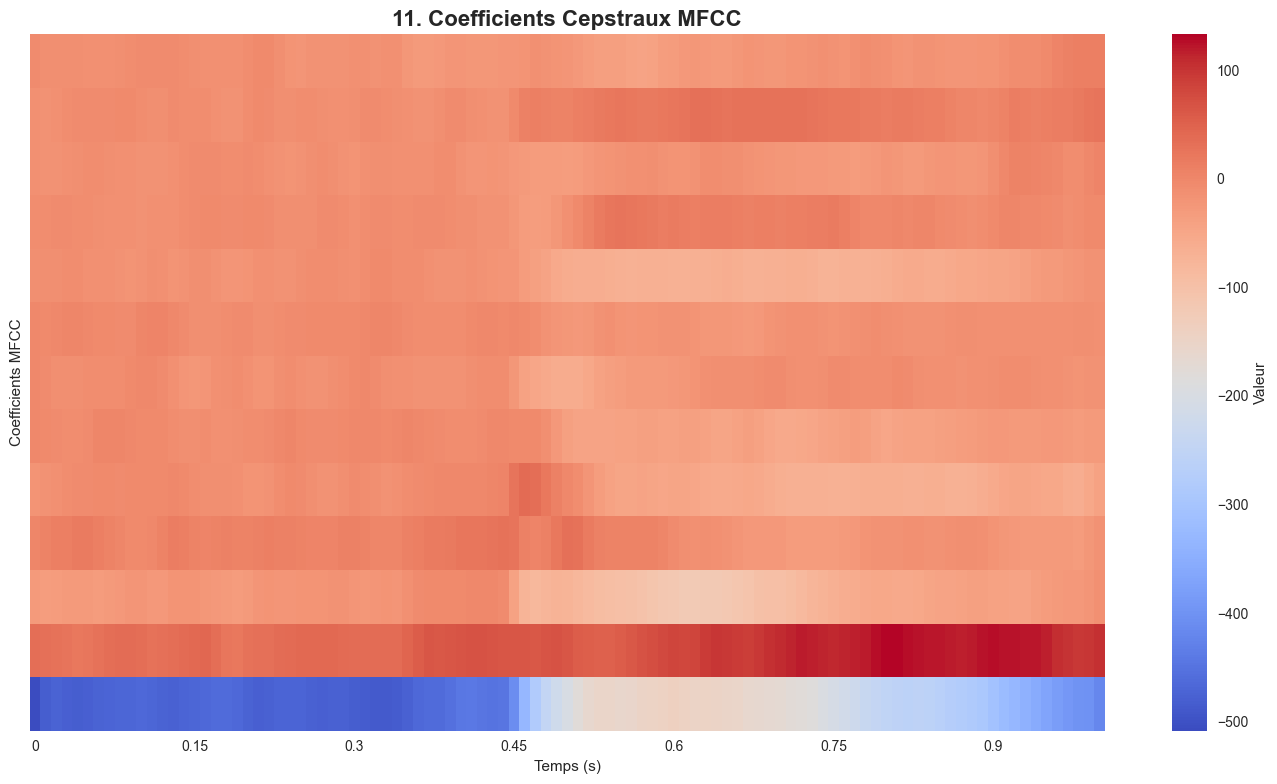

In [14]:
# 11. COEFFICIENTS CEPSTRAUX MFCC
plt.figure(figsize=(14, 8))

mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, 
                            hop_length=hop_length, n_fft=1024)
librosa.display.specshow(mfccs, sr=sr, hop_length=hop_length, 
                         x_axis='time', cmap='coolwarm')
plt.title('11. Coefficients Cepstraux MFCC', fontsize=16, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('Coefficients MFCC')
plt.colorbar(label='Valeur')
plt.tight_layout()
plt.show()

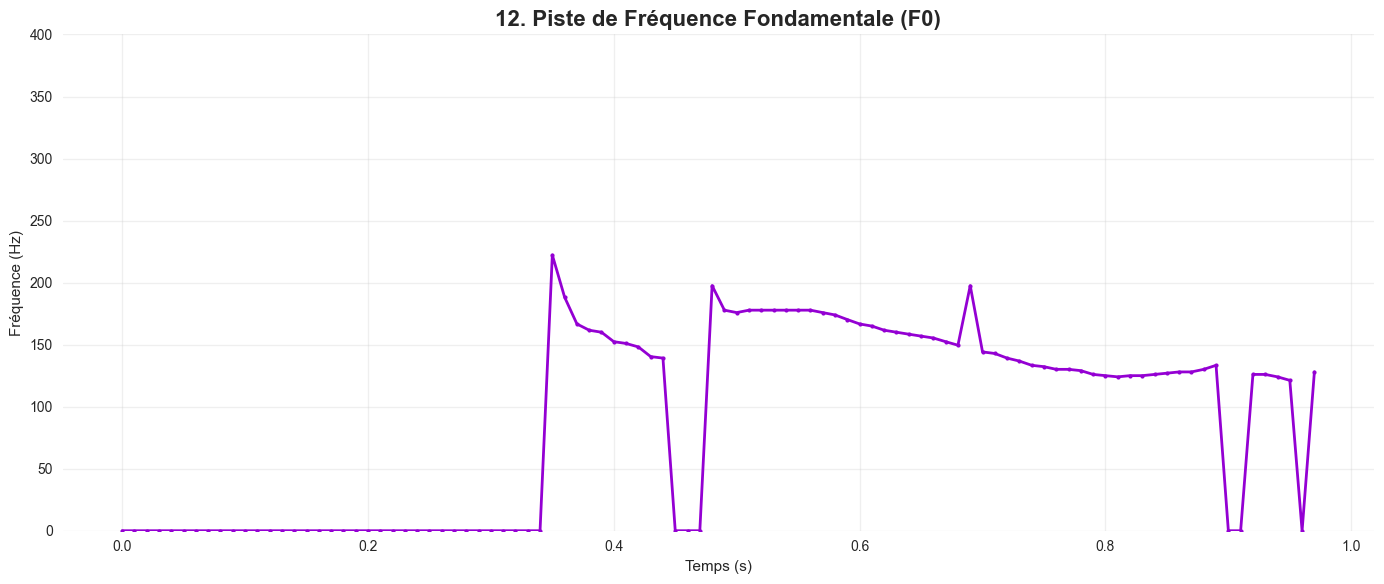

In [15]:
# 12. PISTE DE FRÉQUENCE FONDAMENTALE (F0)
plt.figure(figsize=(14, 6))

def estimate_pitch_frame(frame, sr, f0_min=75, f0_max=400):
    """Estimate pitch using ACF for a single frame"""
    frame = frame - np.mean(frame)
    frame = frame / (np.max(np.abs(frame)) + 1e-10)
    
    correlation = np.correlate(frame, frame, mode='full')
    correlation = correlation[len(correlation)//2:]
    
    min_period = int(sr / f0_max)
    max_period = int(sr / f0_min)
    
    if max_period >= len(correlation):
        return 0
    
    search_window = correlation[min_period:max_period]
    if len(search_window) == 0:
        return 0
    
    peak_index = np.argmax(search_window) + min_period
    
    if correlation[peak_index] < 0.3 * correlation[0]:
        return 0
    
    return sr / peak_index

# Calculate pitch for each frame
pitch_track = []
for i in range(0, len(audio) - frame_length, hop_length):
    frame = audio[i:i + frame_length]
    f0 = estimate_pitch_frame(frame, sr)
    pitch_track.append(f0)

pitch_time = np.arange(len(pitch_track)) * hop_length / sr

plt.plot(pitch_time, pitch_track, linewidth=2, color='darkviolet', marker='o', markersize=3)
plt.title('12. Piste de Fréquence Fondamentale (F0)', fontsize=16, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('Fréquence (Hz)')
plt.grid(True, alpha=0.3)
plt.ylim(0, 400)
plt.tight_layout()
plt.show()

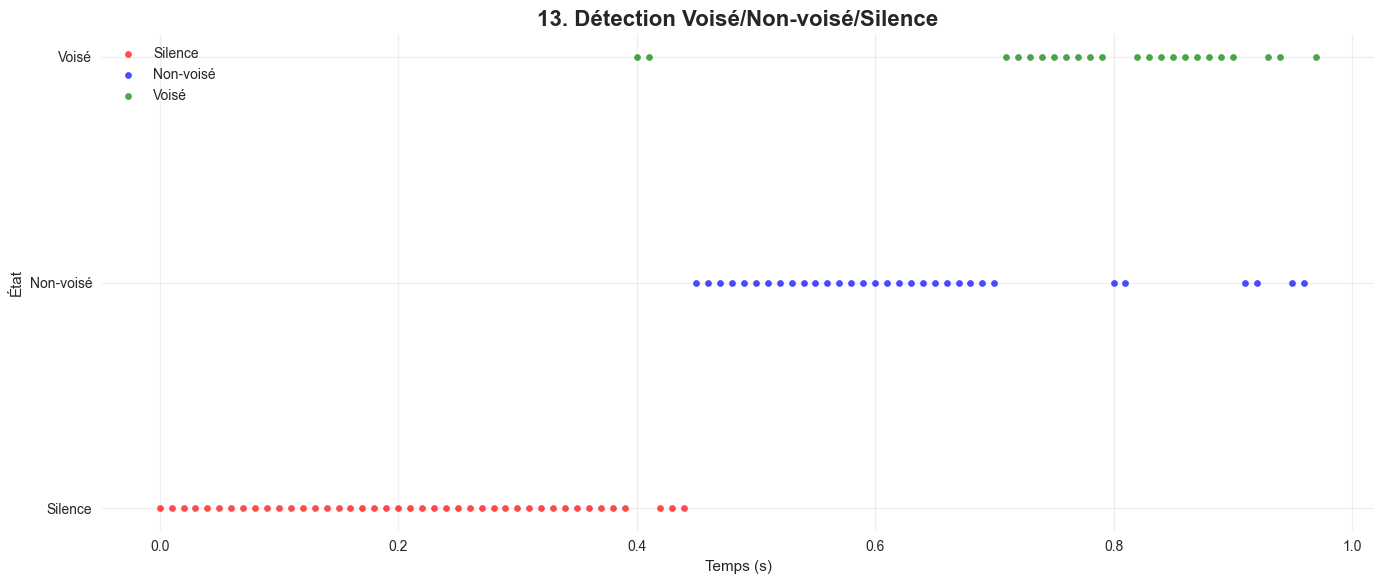

In [16]:
# 13. DÉTECTION VOISÉ/NON-VOISÉ/SILENCE
plt.figure(figsize=(14, 6))

# Simple VAD based on energy and ZCR
energy_threshold = 0.01
zcr_threshold = 0.1

vad_decision = []
for i in range(len(rms_energy)):
    if rms_energy[i] < energy_threshold:
        vad_decision.append(0)  # Silence
    elif zcr[i] > zcr_threshold:
        vad_decision.append(1)  # Unvoiced
    else:
        vad_decision.append(2)  # Voiced

vad_time = np.arange(len(vad_decision)) * hop_length / sr

colors = ['red', 'blue', 'green']
labels = ['Silence', 'Non-voisé', 'Voisé']

for i in range(3):
    indices = np.where(np.array(vad_decision) == i)[0]
    if len(indices) > 0:
        plt.scatter(vad_time[indices], [i] * len(indices), 
                   color=colors[i], label=labels[i], s=20, alpha=0.7)

plt.title('13. Détection Voisé/Non-voisé/Silence', fontsize=16, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('État')
plt.yticks([0, 1, 2], labels)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

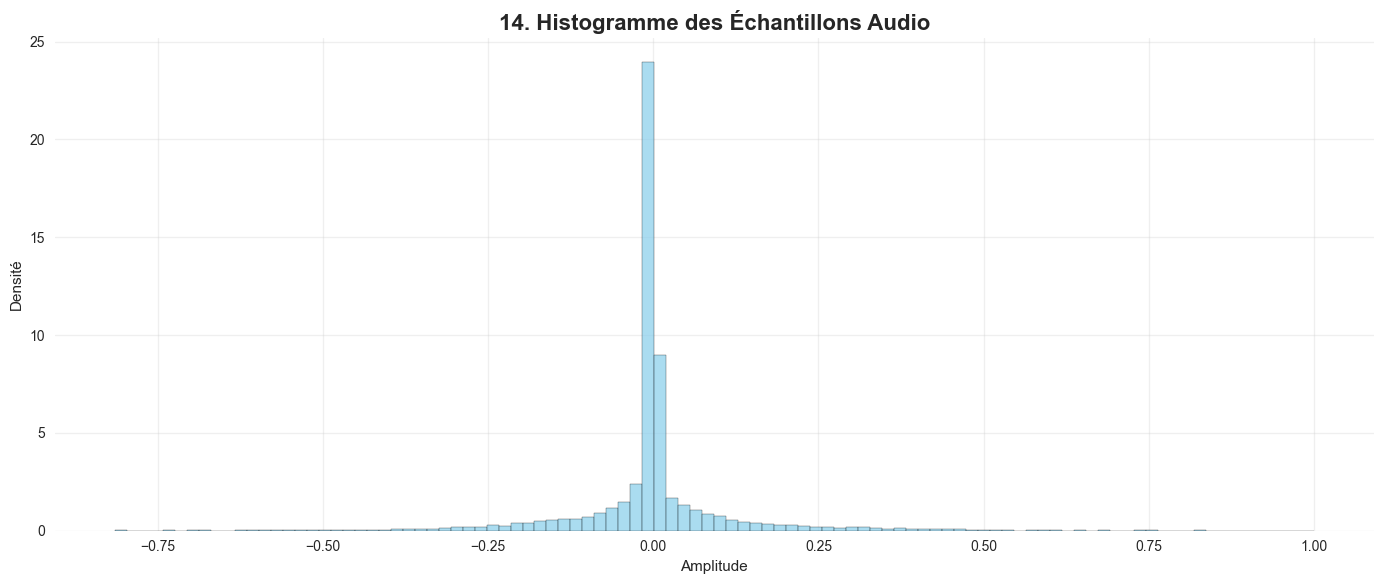

In [17]:
# 14. HISTOGRAMME DES ÉCHANTILLONS AUDIO
plt.figure(figsize=(14, 6))

plt.hist(audio, bins=100, alpha=0.7, density=True, color='skyblue', edgecolor='black')
plt.title('14. Histogramme des Échantillons Audio', fontsize=16, fontweight='bold')
plt.xlabel('Amplitude')
plt.ylabel('Densité')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

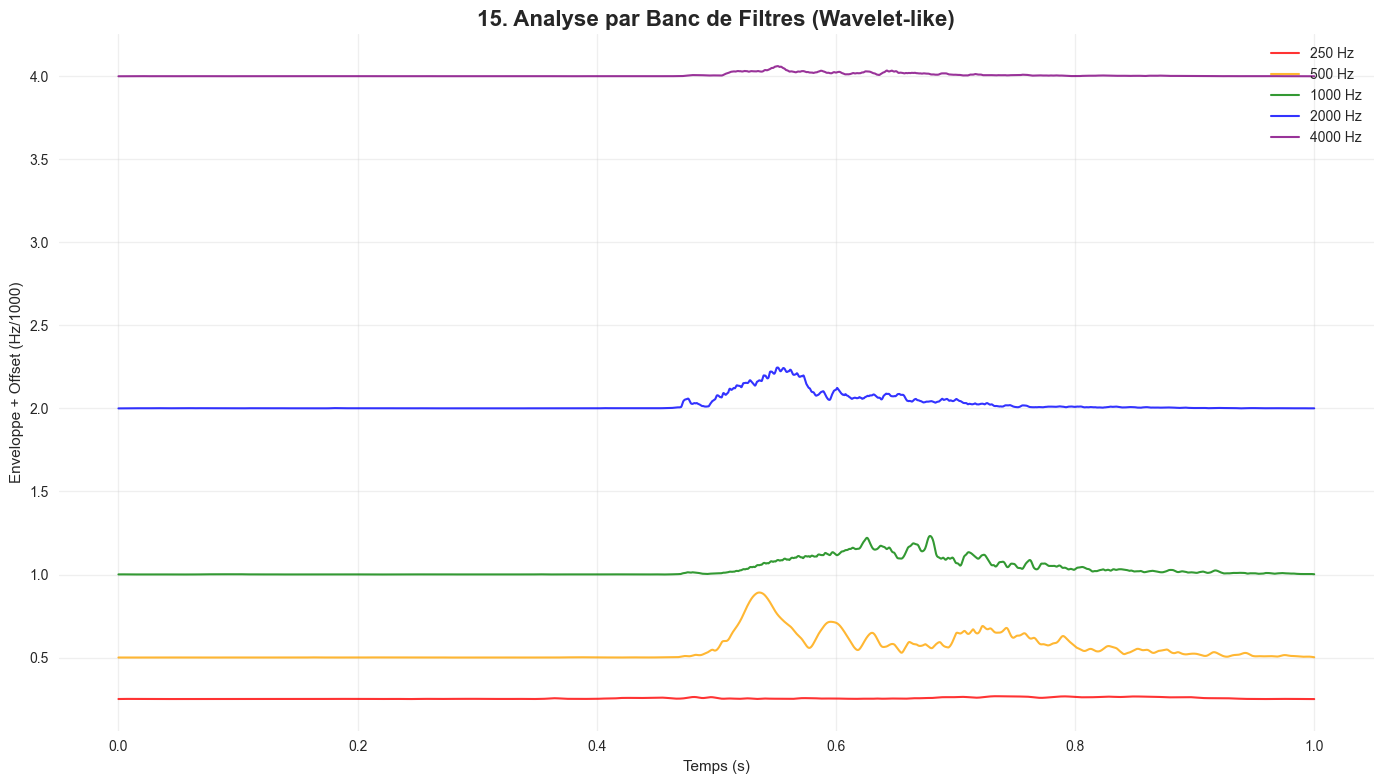

In [18]:
# 15. ANALYSE PAR BANC DE FILTRES (Wavelet-like)
plt.figure(figsize=(14, 8))

center_freqs = [250, 500, 1000, 2000, 4000]
bandwidths = [100, 200, 400, 800, 1600]
colors = ['red', 'orange', 'green', 'blue', 'purple']

for cf, bw, color in zip(center_freqs, bandwidths, colors):
    low = cf - bw/2
    high = cf + bw/2
    b, a = signal.butter(4, [low/(sr/2), high/(sr/2)], btype='band')
    filtered = signal.filtfilt(b, a, audio)
    envelope = np.abs(signal.hilbert(filtered))
    
    # Smooth envelope
    envelope_smooth = np.convolve(envelope, np.ones(100)/100, mode='same')
    plt.plot(time, envelope_smooth + cf/1000, label=f'{cf} Hz', 
             color=color, linewidth=1.5, alpha=0.8)

plt.title('15. Analyse par Banc de Filtres (Wavelet-like)', fontsize=16, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('Enveloppe + Offset (Hz/1000)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# Print summary statistics
print("=" * 50)
print("RÉSUMÉ DE L'ANALYSE")
print("=" * 50)

print(f"\nDurée du signal: {len(audio)/sr:.2f} secondes")
print(f"Fréquence d'échantillonnage: {sr} Hz")
print(f"Nombre d'échantillons: {len(audio)}")

if 'pitch_track' in locals():
    valid_pitches = [p for p in pitch_track if p > 0]
    if valid_pitches:
        print(f"Fréquence fondamentale moyenne: {np.mean(valid_pitches):.1f} Hz")

if 'vad_decision' in locals():
    total_frames = len(vad_decision)
    voiced_percent = vad_decision.count(2) / total_frames * 100
    print(f"Pourcentage de segments voisés: {voiced_percent:.1f}%")

print(f"\nToutes les techniques ont été tracées avec succès!")

RÉSUMÉ DE L'ANALYSE

Durée du signal: 1.00 secondes
Fréquence d'échantillonnage: 16000 Hz
Nombre d'échantillons: 16000
Fréquence fondamentale moyenne: 151.4 Hz
Pourcentage de segments voisés: 23.5%

Toutes les techniques ont été tracées avec succès!


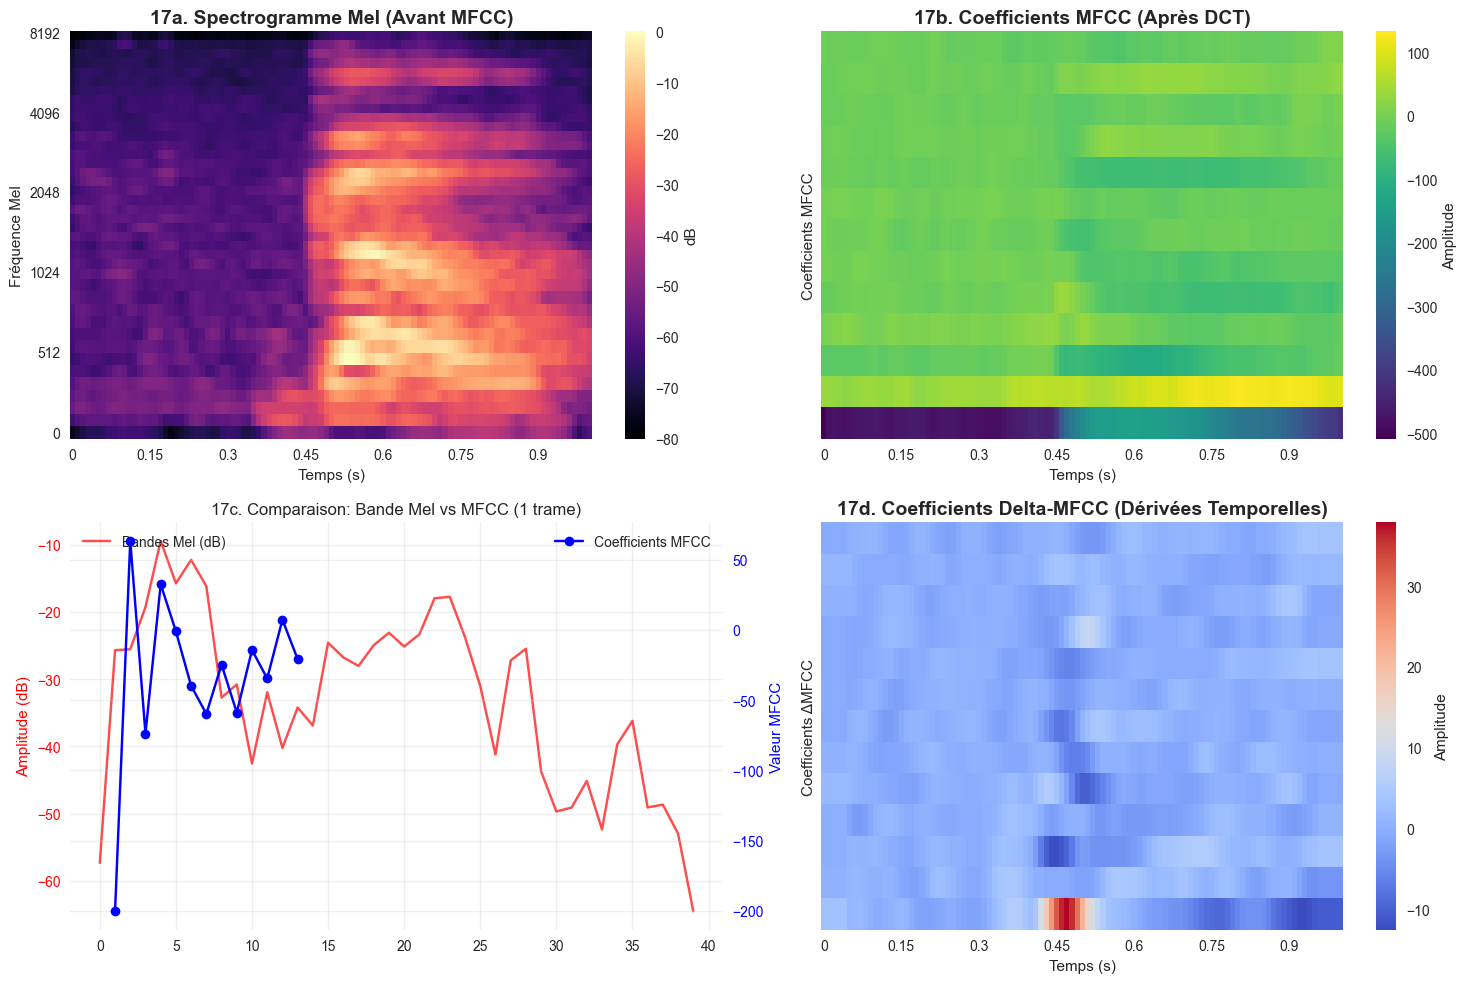

In [20]:
# 17. COMPARAISON MFCC vs SPECTRE MEL
plt.figure(figsize=(15, 10))

# Calculate Mel spectrogram for comparison
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=40, 
                                         hop_length=hop_length, n_fft=1024)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot 1: Mel Spectrogram
plt.subplot(2, 2, 1)
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length, 
                         x_axis='time', y_axis='mel', cmap='magma')
plt.title('17a. Spectrogramme Mel (Avant MFCC)', fontsize=14, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('Fréquence Mel')
plt.colorbar(label='dB')

# Plot 2: MFCC Heatmap
plt.subplot(2, 2, 2)
librosa.display.specshow(mfccs, sr=sr, hop_length=hop_length, 
                         x_axis='time', cmap='viridis')
plt.title('17b. Coefficients MFCC (Après DCT)', fontsize=14, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('Coefficients MFCC')
plt.colorbar(label='Amplitude')

# Plot 3: Single frame comparison
plt.subplot(2, 2, 3)
frame_idx = mfccs.shape[1] // 2  # Middle frame
mel_frame = mel_spec_db[:, frame_idx]
mfcc_frame = mfccs[:, frame_idx]

# Plot Mel bands
plt.plot(mel_frame, label='Bandes Mel (dB)', color='red', alpha=0.7)
plt.ylabel('Amplitude (dB)', color='red')
plt.tick_params(axis='y', labelcolor='red')
plt.legend(loc='upper left')

# Plot MFCC on second y-axis
plt.twinx()
plt.plot(range(1, 14), mfcc_frame, 'o-', label='Coefficients MFCC', color='blue')
plt.ylabel('Valeur MFCC', color='blue')
plt.tick_params(axis='y', labelcolor='blue')
plt.legend(loc='upper right')
plt.title('17c. Comparaison: Bande Mel vs MFCC (1 trame)')
plt.xlabel('Index')

# Plot 4: Delta MFCCs (temporal derivatives)
plt.subplot(2, 2, 4)
delta_mfccs = librosa.feature.delta(mfccs)
librosa.display.specshow(delta_mfccs, sr=sr, hop_length=hop_length, 
                         x_axis='time', cmap='coolwarm')
plt.title('17d. Coefficients Delta-MFCC (Dérivées Temporelles)', fontsize=14, fontweight='bold')
plt.xlabel('Temps (s)')
plt.ylabel('Coefficients ΔMFCC')
plt.colorbar(label='Amplitude')

plt.tight_layout()
plt.show()